In [57]:
# !pip install scikit-learn matplotlib datasets


In [58]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils import resample

In [59]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [60]:
# 1️⃣ Import libraries
import pandas as pd
import zipfile
import os

# 2️⃣ Path to your ZIP file - **Please verify this path and filename**
zip_path = '/content/drive/MyDrive/kaibur/complaints.csv.zip' # <- Corrected ZIP file name

# 3️⃣ **List files in the directory to help verify the path**
print("Files in the directory:")
try:
    print(os.listdir('/content/drive/MyDrive/kaibur/'))
except FileNotFoundError:
    print("Directory not found. Please check the path to your Google Drive folder.")


# 4️⃣ Extract the ZIP file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    extract_folder = '/content/kaibur_extracted'
    zip_ref.extractall(extract_folder)  # extracts to a temp folder

# 5️⃣ List extracted files to see the CSV name
print("\nFiles extracted:")
extracted_files = os.listdir(extract_folder)
print(extracted_files)

# 6️⃣ Load the CSV (replace 'your_file.csv' with the actual name from the previous step)

csv_file_name = 'complaints.csv'
if csv_file_name in extracted_files:
    csv_file = os.path.join(extract_folder, csv_file_name)
    df = pd.read_csv(csv_file)

    # 7️⃣ Print first 5 rows
    print("\nFirst 5 rows of the CSV:")
    print(df.head())
else:
    print(f"\nError: '{csv_file_name}' not found in the extracted files. Please check the extracted file names above and update 'csv_file_name' in the code.")

Files in the directory:
['complaints.csv.zip']

Files extracted:
['complaints.csv']

First 5 rows of the CSV:
  Date received                                            Product  \
0    2020-07-06  Credit reporting, credit repair services, or o...   
1    2025-10-10  Credit reporting or other personal consumer re...   
2    2025-10-03  Credit reporting or other personal consumer re...   
3    2025-09-30  Credit reporting or other personal consumer re...   
4    2019-12-26                        Credit card or prepaid card   

                                  Sub-product  \
0                            Credit reporting   
1                            Credit reporting   
2                            Credit reporting   
3                            Credit reporting   
4  General-purpose credit card or charge card   

                                               Issue  \
0               Incorrect information on your report   
1               Incorrect information on your report   
2     

In [61]:
# Check all column names
df.columns


Index(['Date received', 'Product', 'Sub-product', 'Issue', 'Sub-issue',
       'Consumer complaint narrative', 'Company public response', 'Company',
       'State', 'ZIP code', 'Tags', 'Consumer consent provided?',
       'Submitted via', 'Date sent to company', 'Company response to consumer',
       'Timely response?', 'Consumer disputed?', 'Complaint ID'],
      dtype='object')

In [62]:
# Strip column names to avoid KeyErrors
df.columns = df.columns.str.strip()

# Use 'Consumer complaint narrative' as text; fallback to 'Issue' if empty
df['Text'] = df['Consumer complaint narrative'].fillna(df['Issue'])

# Map Product to numeric categories
label_map = {
    "Credit reporting, credit repair services, or other": 0,
    "Debt collection": 1,
    "Consumer Loan": 2,
    "Mortgage": 3
}
df['Category'] = df['Product'].map(label_map)

# Keep only the columns needed for text classification
df = df[['Text', 'Category']]

# Drop rows with missing text or label
df = df.dropna(subset=['Text', 'Category'])

# Preview cleaned data
df.head()





,Text,Category
13,Struggling to pay mortgage,3.0
35,Written notification about debt,1.0
72,Took or threatened to take negative or legal a...,1.0
79,Took or threatened to take negative or legal a...,1.0
82,Attempts to collect debt not owed,1.0


In [63]:
df.describe()

,Category
count,1.352288e+06
mean,1.658920e+00
std,9.275326e-01
min,1.000000e+00
25%,1.000000e+00
50%,1.000000e+00
75%,3.000000e+00
max,3.000000e+00


In [64]:
df_rows, df_cols = df.shape

print(f"Number of rows: {df_rows}")
print(f"Number of columns: {df_cols}")

Number of rows: 1352288
Number of columns: 2


In [65]:
print(df.isnull().sum())

Text        0
Category    0
dtype: int64


In [66]:
df.duplicated().sum()

np.int64(887949)

In [67]:

print("Data Class Distribution:")
print(df['Category'].value_counts())


Data Class Distribution:
Category
1.0    890976
3.0    429738
2.0     31574
Name: count, dtype: int64


/tmp/ipython-input-2793757945.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df['Category'], palette='viridis')


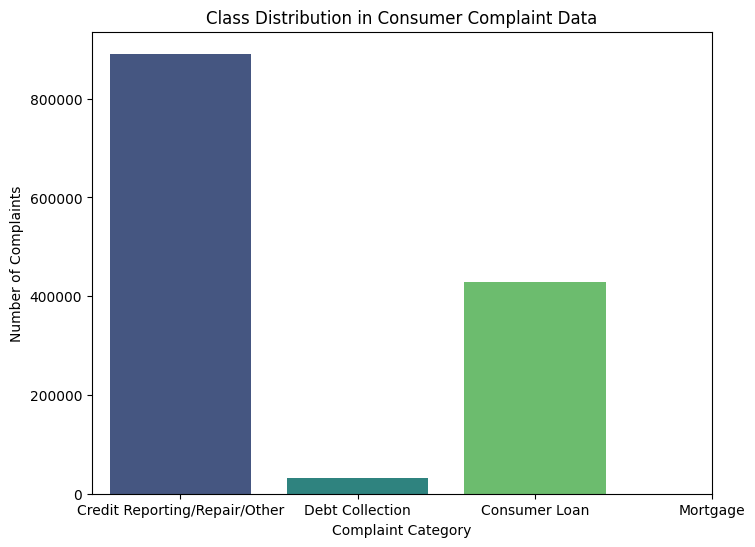

In [68]:
plt.figure(figsize=(8, 6))
sns.countplot(x=df['Category'], palette='viridis')

# Replace numeric ticks with actual category names
plt.xticks(
    ticks=[0, 1, 2, 3],
    labels=[
        "Credit Reporting/Repair/Other",  # class 0
        "Debt Collection",                # class 1
        "Consumer Loan",                  # class 2
        "Mortgage"                        # class 3
    ]
)

plt.title("Class Distribution in Consumer Complaint Data")
plt.xlabel("Complaint Category")
plt.ylabel("Number of Complaints")
plt.show()


In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1352288 entries, 13 to 11424472
Data columns (total 2 columns):
 #   Column    Non-Null Count    Dtype  
---  ------    --------------    -----  
 0   Text      1352288 non-null  object 
 1   Category  1352288 non-null  float64
dtypes: float64(1), object(1)
memory usage: 31.0+ MB


In [70]:
df.head()


,Text,Category
13,Struggling to pay mortgage,3.0
35,Written notification about debt,1.0
72,Took or threatened to take negative or legal a...,1.0
79,Took or threatened to take negative or legal a...,1.0
82,Attempts to collect debt not owed,1.0


In [71]:
# Make sure Text column has no nulls
df['Text'] = df['Text'].fillna('')

# 1. Number of characters (fast with .str.len)
df["No_of_Characters"] = df["Text"].str.len()

# 2. Number of words (split on whitespace, much faster than nltk.tokenize)
df["No_of_Words"] = df["Text"].apply(lambda x: len(str(x).split()))

# 3. Number of sentences (approximate using '.')
df["No_of_Sentences"] = df["Text"].apply(lambda x: len(str(x).split('.')))

# View summary
df.describe()


,Category,No_of_Characters,No_of_Words,No_of_Sentences
count,1.352288e+06,1.352288e+06,1.352288e+06,1.352288e+06
mean,1.658920e+00,4.495719e+02,7.916469e+01,5.109488e+00
std,9.275326e-01,1.021680e+03,1.800751e+02,1.027263e+01
min,1.000000e+00,5.000000e+00,1.000000e+00,1.000000e+00
25%,1.000000e+00,3.300000e+01,4.000000e+00,1.000000e+00
50%,1.000000e+00,4.000000e+01,6.000000e+00,1.000000e+00
75%,3.000000e+00,4.710000e+02,8.500000e+01,6.000000e+00
max,3.000000e+00,3.261600e+04,6.095000e+03,3.837000e+03


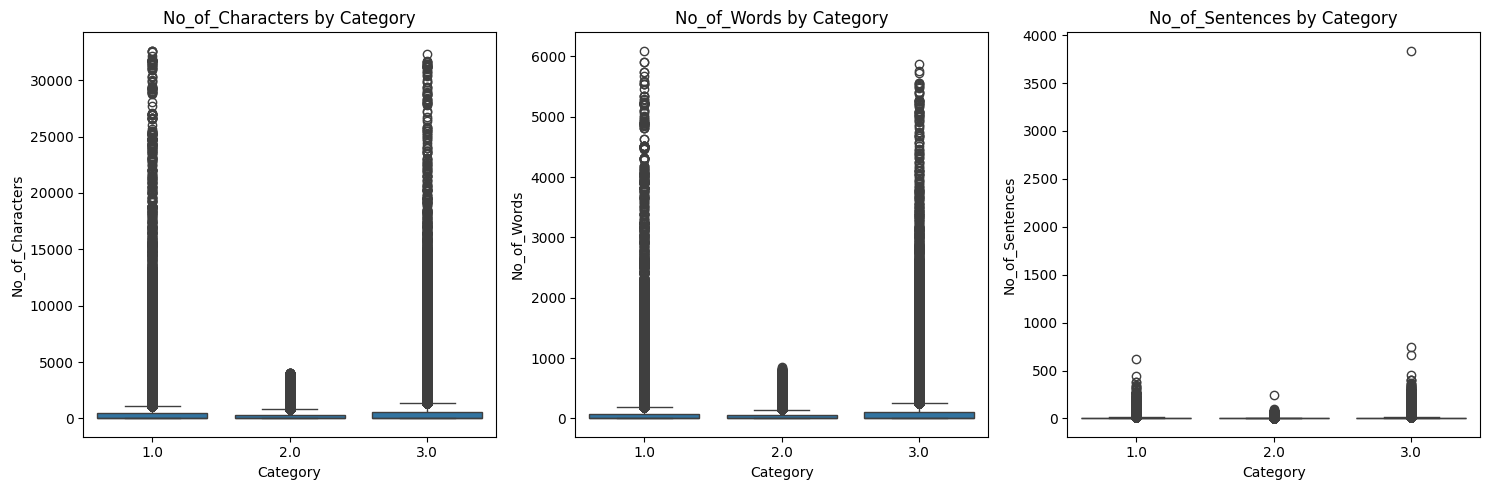

In [72]:
# prompt: plt.figure(figsize=(12, 8))
# sns.pairplot(data=traindata[numerical_features + ['label']], hue="label", palette="viridis")
# plt.title("Pair Plot for Test Data")

import matplotlib.pyplot as plt
import seaborn as sns

numerical_features = ['No_of_Characters', 'No_of_Words', 'No_of_Sentences']

plt.figure(figsize=(15, 5))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(1, 3, i)
    sns.boxplot(x='Category', y=feature, data=df)
    plt.title(f"{feature} by Category")
plt.tight_layout()
plt.show()


In [73]:

import matplotlib.pyplot as plt
import seaborn as sns


In [74]:
import pandas as pd

import numpy as np

def remove_outliers_iqr(df, columns, threshold=1.5):
    """Removes outliers from a DataFrame using the IQR method.
    Args:
        df: The input DataFrame.
        columns: A list of column names to check for outliers.
        threshold: The IQR threshold for outlier detection (default is 1.5).
    Returns:
        A new DataFrame with outliers removed.
    """
    df_no_outliers = df.copy()
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR
        df_no_outliers = df_no_outliers[~((df_no_outliers[col] < lower_bound) | (df_no_outliers[col] > upper_bound))]
    return df_no_outliers

# Example usage (replace with your actual column names and DataFrame)
numerical_features = ['No_of_Characters', 'No_of_Words', 'No_of_Sentences'] # Corrected column name
df_no_outliers = remove_outliers_iqr(df, numerical_features) # Used df instead of data
#Check the shape of the data
print("Original DataFrame shape:", df.shape)
print("DataFrame shape after removing outliers:", df_no_outliers.shape)

# Update df to the new DataFrame without outliers
df = df_no_outliers

Original DataFrame shape: (1352288, 5)
DataFrame shape after removing outliers: (1167318, 5)


In [75]:
# Print all the column names in your dataset
print("Columns in the dataset:", df.columns)


Columns in the dataset: Index(['Text', 'Category', 'No_of_Characters', 'No_of_Words',
       'No_of_Sentences'],
      dtype='object')


PREPOCSSING



In [76]:

print("\033[1m\u001b[45;1m The First 5 Texts:\033[0m", *df["Text"][:5], sep="\n")

 The First 5 Texts:
Struggling to pay mortgage
Written notification about debt
Took or threatened to take negative or legal action
Took or threatened to take negative or legal action
Attempts to collect debt not owed


In [77]:
import re

def Clean(Text):
    if Text is None:
        return ''

    sms = re.sub('[^a-zA-Z]', ' ', Text)
    sms = sms.lower()
    sms = sms.split()
    sms = ' '.join(sms)
    return sms

df['Text'] = df['Text'].astype(str)
df["Clean_Text"] = df["Text"].apply(Clean)
print("\033[1m\u001b[45;1m The First 5 Texts after cleaning:\033[0m",*df["Clean_Text"][:5], sep = "\n")

 The First 5 Texts after cleaning:
struggling to pay mortgage
written notification about debt
took or threatened to take negative or legal action
took or threatened to take negative or legal action
attempts to collect debt not owed


In [78]:

import nltk
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')



[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

Tokenization


In [79]:
df['Tokenize_Text'] = df.apply(lambda row: nltk.word_tokenize(row["Clean_Text"]), axis=1)
print("\033[1m\u001b[45;1m The First 5 Texts after Tokenizing:\033[0m", *df["Tokenize_Text"][:5], sep="\n")

 The First 5 Texts after Tokenizing:
['struggling', 'to', 'pay', 'mortgage']
['written', 'notification', 'about', 'debt']
['took', 'or', 'threatened', 'to', 'take', 'negative', 'or', 'legal', 'action']
['took', 'or', 'threatened', 'to', 'take', 'negative', 'or', 'legal', 'action']
['attempts', 'to', 'collect', 'debt', 'not', 'owed']


Removing stop words


In [80]:

def remove_stopwords(text):
    stop_words = set(stopwords.words("english"))
    filtered_text = [word for word in text if word not in stop_words]
    return filtered_text

df["Nostopword_Text"] = df["Tokenize_Text"].apply(remove_stopwords)


print("\033[1m\u001b[45;1m The First 5 Texts after removing the stopwords:\033[0m",*df["Nostopword_Text"][:5], sep = "\n")

 The First 5 Texts after removing the stopwords:
['struggling', 'pay', 'mortgage']
['written', 'notification', 'debt']
['took', 'threatened', 'take', 'negative', 'legal', 'action']
['took', 'threatened', 'take', 'negative', 'legal', 'action']
['attempts', 'collect', 'debt', 'owed']


lEMMA


In [81]:
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

def lemmatize_word(tokens):
    return [lemmatizer.lemmatize(word, pos='v') for word in tokens]

df["Lemmatized_Text"] = df["Nostopword_Text"].apply(lemmatize_word)

print("\033[1m\u001b[45;1m The First 5 Texts after Lemmatization:\033[0m",
      *df["Lemmatized_Text"][:5], sep="\n")


 The First 5 Texts after Lemmatization:
['struggle', 'pay', 'mortgage']
['write', 'notification', 'debt']
['take', 'threaten', 'take', 'negative', 'legal', 'action']
['take', 'threaten', 'take', 'negative', 'legal', 'action']
['attempt', 'collect', 'debt', 'owe']


In [82]:
df.head()

,Text,Category,No_of_Characters,No_of_Words,No_of_Sentences,Clean_Text,Tokenize_Text,Nostopword_Text,Lemmatized_Text
13,Struggling to pay mortgage,3.0,26,4,1,struggling to pay mortgage,"[struggling, to, pay, mortgage]","[struggling, pay, mortgage]","[struggle, pay, mortgage]"
35,Written notification about debt,1.0,31,4,1,written notification about debt,"[written, notification, about, debt]","[written, notification, debt]","[write, notification, debt]"
72,Took or threatened to take negative or legal a...,1.0,51,9,1,took or threatened to take negative or legal a...,"[took, or, threatened, to, take, negative, or,...","[took, threatened, take, negative, legal, action]","[take, threaten, take, negative, legal, action]"
79,Took or threatened to take negative or legal a...,1.0,51,9,1,took or threatened to take negative or legal a...,"[took, or, threatened, to, take, negative, or,...","[took, threatened, take, negative, legal, action]","[take, threaten, take, negative, legal, action]"
82,Attempts to collect debt not owed,1.0,33,6,1,attempts to collect debt not owed,"[attempts, to, collect, debt, not, owed]","[attempts, collect, debt, owed]","[attempt, collect, debt, owe]"


Vectorization


In [83]:
corpus = [' '.join(tokens) for tokens in df["Lemmatized_Text"]]

print("\033[1m\u001b[45;1m The First 5 lines in corpus:\033[0m",
      *corpus[:5], sep="\n")


 The First 5 lines in corpus:
struggle pay mortgage
write notification debt
take threaten take negative legal action
take threaten take negative legal action
attempt collect debt owe


In [84]:
# ✅ 1. Ensure Lemmatized column exists
if "Lemmatized_Text" not in df.columns:
    raise KeyError("Column 'Lemmatized_Text' not found. Make sure it's created.")

print(df["Lemmatized_Text"].head())

# ✅ 2. FAST corpus creation (list comprehension - faster than loop)
corpus = [' '.join(tokens) for tokens in df["Lemmatized_Text"]]

print("\033[1m\u001b[45;1mThe First 5 lines in corpus:\033[0m",
      *corpus[:5], sep="\n")

# ✅ 3. Optimized TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    max_features=5000,
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.9
)

X = tfidf.fit_transform(corpus)

print("✅ TF-IDF Matrix Created!")
print("Shape of X:", X.shape)

# ✅ 4. Preview features
feature_names = tfidf.get_feature_names_out()
print("Total features:", len(feature_names))
print("Sample features:", feature_names[:20])


13                          [struggle, pay, mortgage]
35                        [write, notification, debt]
72    [take, threaten, take, negative, legal, action]
79    [take, threaten, take, negative, legal, action]
82                      [attempt, collect, debt, owe]
Name: Lemmatized_Text, dtype: object
The First 5 lines in corpus:
struggle pay mortgage
write notification debt
take threaten take negative legal action
take threaten take negative legal action
attempt collect debt owe
✅ TF-IDF Matrix Created!
Shape of X: (1167318, 5000)
Total features: 5000
Sample features: ['aargon' 'ability' 'ability obtain' 'ability recovery' 'able' 'able get'
 'able make' 'able pay' 'able provide' 'absence' 'absolutely' 'abuse'
 'abusive' 'abusive deceptive' 'accept' 'accept payment' 'acceptable'
 'acceptance' 'access' 'access account']


In [85]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()
X = tfidf.fit_transform(corpus)

print("Matrix type:", type(X))
print("Shape:", X.shape)
print("Data type:", X.dtype)


Matrix type: <class 'scipy.sparse._csr.csr_matrix'>
Shape: (1167318, 52844)
Data type: float64


In [86]:
print(df['Category'].head())
print(df['Category'].dtype)


13    3.0
35    1.0
72    1.0
79    1.0
82    1.0
Name: Category, dtype: float64
float64


In [87]:


from sklearn.preprocessing import LabelEncoder

# Encode the 'Category' column (if not numeric yet)
le = LabelEncoder()
y = le.fit_transform(df['Category'])




In [88]:
print(df.columns)


Index(['Text', 'Category', 'No_of_Characters', 'No_of_Words',
       'No_of_Sentences', 'Clean_Text', 'Tokenize_Text', 'Nostopword_Text',
       'Lemmatized_Text'],
      dtype='object')


In [89]:
print("Number of rows in df:", len(df))
print("Number of rows with Category:", df['Category'].notna().sum())
print("Number of rows with Lemmatized_Text:", df['Lemmatized_Text'].notna().sum())


Number of rows in df: 1167318
Number of rows with Category: 1167318
Number of rows with Lemmatized_Text: 1167318


In [90]:
df.head()

,Text,Category,No_of_Characters,No_of_Words,No_of_Sentences,Clean_Text,Tokenize_Text,Nostopword_Text,Lemmatized_Text
13,Struggling to pay mortgage,3.0,26,4,1,struggling to pay mortgage,"[struggling, to, pay, mortgage]","[struggling, pay, mortgage]","[struggle, pay, mortgage]"
35,Written notification about debt,1.0,31,4,1,written notification about debt,"[written, notification, about, debt]","[written, notification, debt]","[write, notification, debt]"
72,Took or threatened to take negative or legal a...,1.0,51,9,1,took or threatened to take negative or legal a...,"[took, or, threatened, to, take, negative, or,...","[took, threatened, take, negative, legal, action]","[take, threaten, take, negative, legal, action]"
79,Took or threatened to take negative or legal a...,1.0,51,9,1,took or threatened to take negative or legal a...,"[took, or, threatened, to, take, negative, or,...","[took, threatened, take, negative, legal, action]","[take, threaten, take, negative, legal, action]"
82,Attempts to collect debt not owed,1.0,33,6,1,attempts to collect debt not owed,"[attempts, to, collect, debt, not, owed]","[attempts, collect, debt, owed]","[attempt, collect, debt, owe]"


MODEL BUILDING


In [91]:
from sklearn.model_selection import train_test_split



Y = df["Category"]
X = df["Lemmatized_Text"]

# Convert list of lemmas to strings
X = [' '.join(lemmas) for lemmas in X]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.2, random_state=42, stratify=Y
)

# Check distributions
print("Training set label distribution:\n", y_train.value_counts())
print("Testing set label distribution:\n", y_test.value_counts())

Training set label distribution:
 Category
1.0    629894
3.0    281882
2.0     22078
Name: count, dtype: int64
Testing set label distribution:
 Category
1.0    157474
3.0     70470
2.0      5520
Name: count, dtype: int64


In [92]:
print(f"Length of X: {len(X)}")
print(f"Length of y: {len(Y)}")
print(f"Length of X_train: {len(X_train)}")
print(f"Length of y_train: {len(y_train)}")

Length of X: 1167318
Length of y: 1167318
Length of X_train: 933854
Length of y_train: 933854


KNN


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Accuracy: 0.9904696227255594

Classification Report:
               precision    recall  f1-score   support

         1.0       0.99      1.00      0.99    157474
         2.0       0.95      0.88      0.91      5520
         3.0       0.99      0.99      0.99     70470

    accuracy                           0.99    233464
   macro avg       0.98      0.95      0.97    233464
weighted avg       0.99      0.99      0.99    233464



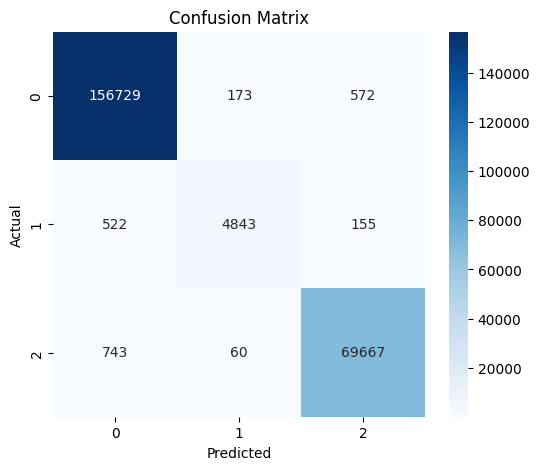

In [93]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


# -----------------------------
bow_vectorizer = CountVectorizer(max_df=0.8, min_df=5, max_features=2000, ngram_range=(1,2))
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, min_df=5, max_features=2000, ngram_range=(1,2))

pipeline = Pipeline([
    ('features', FeatureUnion([
        ('bow', bow_vectorizer),
        ('tfidf', tfidf_vectorizer)
    ])),
    ('lr', LogisticRegression(max_iter=500, solver='lbfgs', multi_class='multinomial'))
])

-
pipeline.fit(X_train, y_train)


y_pred = pipeline.predict(X_test)


print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()




navive byes

In [94]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report

pipeline_nb = Pipeline([
    ('tfidf', TfidfVectorizer(max_df=0.8, min_df=5, max_features=5000, ngram_range=(1,2))),
    ('nb', MultinomialNB())
])

pipeline_nb.fit(X_train, y_train)
y_pred_nb = pipeline_nb.predict(X_test)

print("Naive Bayes Accuracy:", accuracy_score(y_test, y_pred_nb))
print(classification_report(y_test, y_pred_nb))



Naive Bayes Accuracy: 0.9816160093204948
              precision    recall  f1-score   support

         1.0       0.98      1.00      0.99    157474
         2.0       0.96      0.85      0.90      5520
         3.0       0.99      0.96      0.97     70470

    accuracy                           0.98    233464
   macro avg       0.98      0.94      0.96    233464
weighted avg       0.98      0.98      0.98    233464



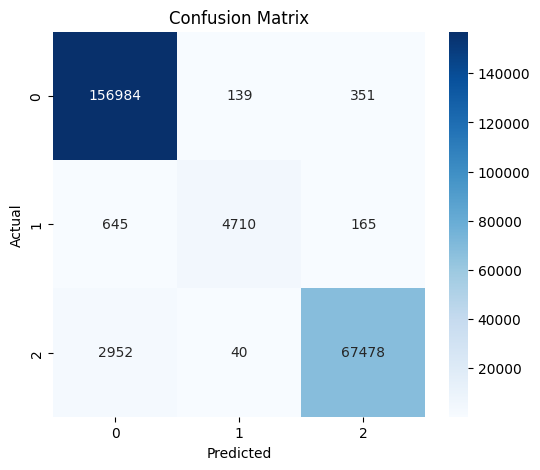

In [95]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred_nb)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

linear svm


Linear SVM Accuracy: 0.9904267895692698

Classification Report:
               precision    recall  f1-score   support

         1.0       0.99      1.00      0.99    157474
         2.0       0.97      0.86      0.91      5520
         3.0       0.99      0.99      0.99     70470

    accuracy                           0.99    233464
   macro avg       0.98      0.95      0.97    233464
weighted avg       0.99      0.99      0.99    233464



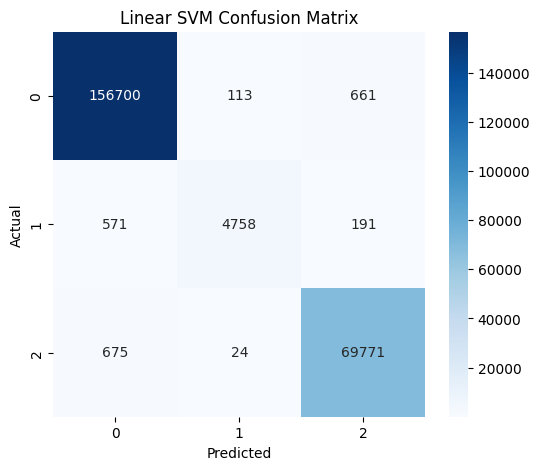

In [96]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# Linear SVM pipeline
pipeline_svm = Pipeline([
    ('tfidf', TfidfVectorizer(
        max_df=0.8,
        min_df=10,
        max_features=2000,
        ngram_range=(1,1)
    )),
    ('svm', LinearSVC(max_iter=5000))
])


# Train
pipeline_svm.fit(X_train, y_train)

# Predict
y_pred_svm = pipeline_svm.predict(X_test)

# Evaluate
print("Linear SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print("\nClassification Report:\n", classification_report(y_test, y_pred_svm))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Linear SVM Confusion Matrix')
plt.show()


RandomForestClassifier

Random Forest Accuracy: 0.9625895212966453

Classification Report:
               precision    recall  f1-score   support

         1.0       0.95      1.00      0.97    157474
         2.0       1.00      0.54      0.70      5520
         3.0       1.00      0.91      0.95     70470

    accuracy                           0.96    233464
   macro avg       0.98      0.82      0.88    233464
weighted avg       0.96      0.96      0.96    233464



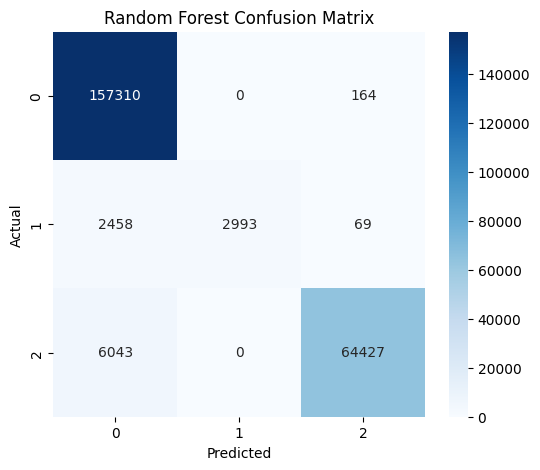

In [97]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------
# 1️⃣ Use only TF-IDF (BOW + TF-IDF combined slows RF)
# -----------------------------
tfidf = TfidfVectorizer(
    max_df=0.8,
    min_df=10,
    max_features=2000,
    ngram_range=(1,1)
)

# -----------------------------
# 2️⃣ Random Forest pipeline
# -----------------------------
rf_pipeline = Pipeline([
    ('tfidf', tfidf),
    ('rf', RandomForestClassifier(
        n_estimators=100,
        max_depth=15,
        min_samples_split=10,
        min_samples_leaf=5,
        n_jobs=-1
    ))
])

# -----------------------------
# 3️⃣ Train
# -----------------------------
rf_pipeline.fit(X_train, y_train)

# -----------------------------
# 4️⃣ Predict
# -----------------------------
y_pred = rf_pipeline.predict(X_test)

# -----------------------------
# 5️⃣ Evaluate
# -----------------------------
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Random Forest Confusion Matrix')
plt.show()


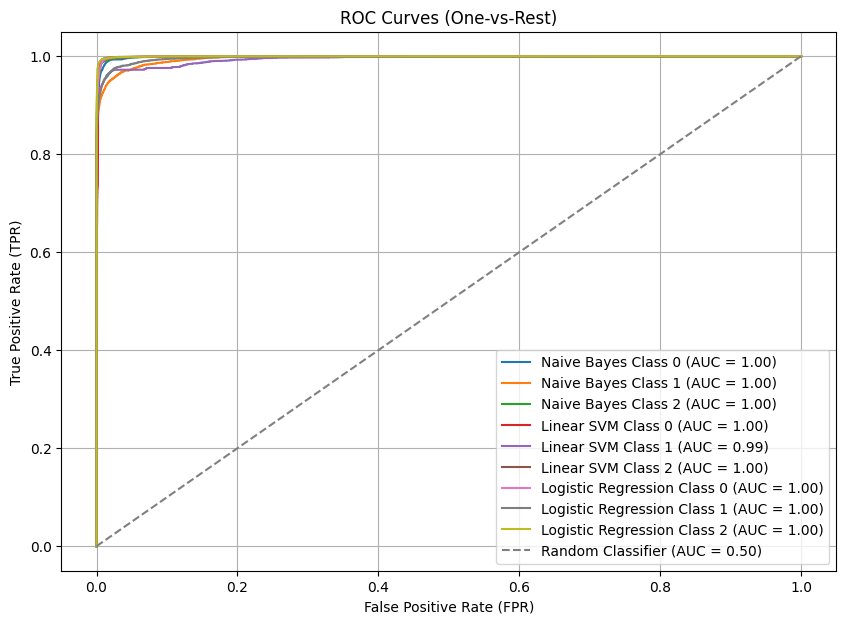

In [98]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import label_binarize

# Dictionary of pipelines
pipelines = {
    'Naive Bayes': pipeline_nb,
    'Linear SVM': pipeline_svm,
    'Logistic Regression': pipeline,
    # 'Random Forest': rf_pipeline  # Optional: very slow
}

plt.figure(figsize=(10, 7))

# Binarize the output for OvR
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
n_classes = y_test_bin.shape[1]

for name, model in pipelines.items():
    try:
        # Try predict_proba first
        if hasattr(model, "predict_proba"):
            y_score = model.predict_proba(X_test)
        elif hasattr(model, "decision_function"):
             y_score = model.decision_function(X_test)
        else:
            print(f"Model {name} does not support probability or decision scores, skipping ROC.")
            continue

        # Compute ROC curve and ROC area for each class using OvR
        for i in range(n_classes):
            fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f'{name} Class {i} (AUC = {roc_auc:.2f})')

    except Exception as e:
        print(f"An error occurred for model {name}: {e}")
        continue


# Random classifier line
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Classifier (AUC = 0.50)')

plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curves (One-vs-Rest)')
plt.legend(loc='lower right')
plt.grid()
plt.show()

Random Forest Accuracy: 0.9626
Linear SVM Accuracy: 0.9904
Naive Bayes Accuracy: 0.9816
Logistic Regression Accuracy: 0.9626


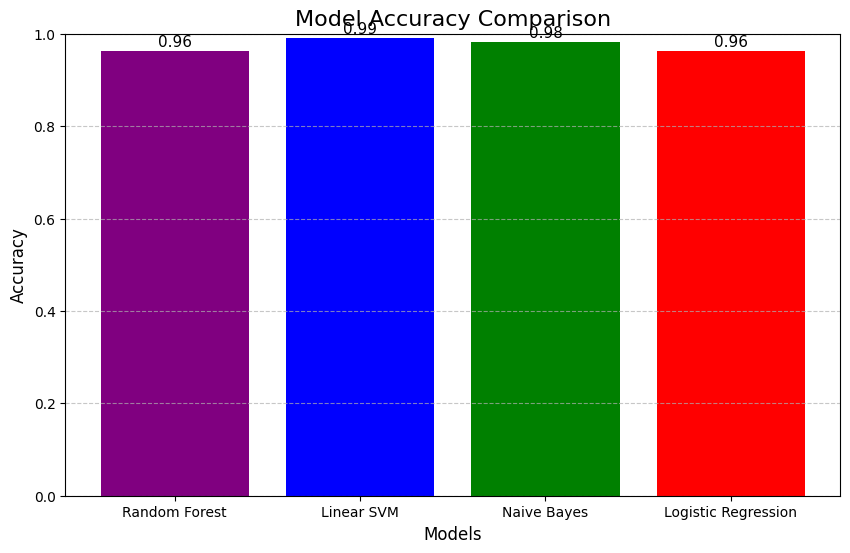

In [99]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# 1️⃣ Compute accuracies
accuracy_rf = accuracy_score(y_test, y_pred)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
accuracy_nb = accuracy_score(y_test, y_pred_nb)
accuracy_lr = accuracy_score(y_test, y_pred)

# 2️⃣ Prepare models and accuracy list
models = ["Random Forest", "Linear SVM", "Naive Bayes", "Logistic Regression"]
accuracies = [accuracy_rf, accuracy_svm, accuracy_nb, accuracy_lr]

# 3️⃣ Print accuracies
for model, acc in zip(models, accuracies):
    print(f"{model} Accuracy: {acc:.4f}")

# 4️⃣ Plot comparison
plt.figure(figsize=(10,6))
colors = ['purple', 'blue', 'green', 'red']
plt.bar(models, accuracies, color=colors)
plt.ylim(0, 1)
plt.title('Model Accuracy Comparison', fontsize=16)
plt.xlabel('Models', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)

# Annotate bars with accuracy
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.01, f'{acc:.2f}', ha='center', fontsize=11)

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()



